## Attendance Data Cleaning

Using python to clean and analyze quarterly employee attendance data exported from ADP

### Overview

There are two different types of employees, 12 MTH and 11 MTH employees, with tow different attendance calculations:

- 11 MTH Employee Attendance Calculations
    - 'ABSENT','SICK','UNPAID TIME OFF','PERSONAL','LONGEVITY DAYS','VACATION' - **Unexcused Absences**
    - 'COVID SICK','JURY','PROFESSIONAL DEVELOPMENT','RELIGIOUS OBSERVATION' - **Excused Absences**
    
    
- 12 MTH Employee Attendance Calculations
    - 'ABSENT','SICK','UNPAID TIME OFF','PERSONAL','LONGEVITY DAYS' - **Unexcused Absences**
    - 'COVID SICK','JURY','PROFESSIONAL DEVELOPMENT','RELIGIOUS OBSERVATION','VACATION' - **Excused Absences**
        - VACATION counts as an excused absence for 12 MTH due to having to input vacation time for HOLIDAYS.

In [1]:
#Importing Packages
import pandas as pd
import datetime as dt
import string as str
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r"/Users/scipio/Downloads/Staff_Att_09.24-02.24.csv", parse_dates = ['In_time','Out_time'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19736 entries, 0 to 19735
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Company_Code       19736 non-null  object        
 1   Last_Name          19736 non-null  object        
 2   First_Name         19736 non-null  object        
 3   Position_ID        19736 non-null  object        
 4   Employee_ID        19736 non-null  int64         
 5   Worked_Department  19736 non-null  int64         
 6   State              19736 non-null  object        
 7   In_time            19736 non-null  datetime64[ns]
 8   Out_time           17701 non-null  datetime64[ns]
 9   Out_Punch_Type     72 non-null     object        
 10  Hours              19736 non-null  float64       
 11  Campus             19736 non-null  object        
 12  Contract_Type      19736 non-null  object        
 13  Pay_Code           5452 non-null   object        
 14  Notes 

In [4]:
df.shape

(19736, 15)

In [5]:
#Date Range
df['In_time'].agg(['min','max'])

min   2023-08-16
max   2024-03-01
Name: In_time, dtype: datetime64[ns]

In [6]:
#Filtering df based on REGSAL, REGSAL indicative of pay day
df = df[df['Pay_Code']!= 'REGSAL']

In [7]:
df['Contract_Type'].unique() # < - unique contract types

array(['11 MTH', '12 MTH'], dtype=object)

In [8]:
#Adding month column
df['Month'] = df['In_time'].dt.strftime('%Y-%m')

In [9]:
#Adding Day Type
def day_type(x):
    if x >=5: # <- greater than or equal to a full day
        return 1
    elif x <= 4:
        return 0.5
    elif x == 0: # <- Will
        return 0
    
df['Day_Type'] = df['Hours'].apply(lambda x:day_type(x))

In [10]:
#Excused Absences
def Excused (row):
    if row['Contract_Type'] == '11 MTH': # <- conditions for 11 MTH Employees
        if row['Pay_Code'] in (['COVID SICK','JURY','PROFESSIONAL DEVELOPMENT','RELIGIOUS OBSERVATION']):
            return 1
        else:
            return 0
    elif row['Contract_Type'] == '12 MTH': # <- conditions for 12 MTH Employees
        if row['Pay_Code'] in (['COVID SICK','JURY','PROFESSIONAL DEVELOPMENT','RELIGIOUS OBSERVATION','VACATION']):
            return 1
        else:
            return 0

df['Excused'] = df.apply(Excused, axis = 1)

In [11]:
#Unexcused Absences
def Unexcused (row):
    if row['Contract_Type'] == '11 MTH': # <- conditions for 11 MTH Employees
        if row['Pay_Code'] in (['ABSENT','SICK','UNPAID TIME OFF','PERSONAL','LONGEVITY DAYS','VACATION']):
            return 1
        else:
            return 0
    elif row['Contract_Type'] == '12 MTH': # <- conditions for 12 MTH Employees
        if row['Pay_Code'] in (['ABSENT','SICK','UNPAID TIME OFF','PERSONAL','LONGEVITY DAYS']):
            return 1
        else:
            return 0

df['Unexcused'] = df.apply(Unexcused, axis = 1)

In [12]:
#School Days
def School_Days(x):
    if x == '2023-09':
        return 19
    elif x == '2023-10':
        return 21
    elif x == '2023-11':
        return 16
    elif x == '2023-12':
        return 16
    elif x == '2024-01':
        return 19
    elif x == '2024-02':
        return 16
    
df['School_Days'] = df['Month'].apply(lambda x:School_Days(x))    

In [13]:
#Service Days
def Service_Days(x):
    if x == '2023-09':
        return 20
    elif x == '2023-10':
        return 21
    elif x == '2023-11':
        return 17
    elif x == '2023-12':
        return 16
    elif x == '2024-01':
        return 19
    elif x == '2024-02':
        return 18
    
df['Service_Days'] = df['Month'].apply(lambda x:School_Days(x))    

In [14]:
#Excused and Unexcused attendance calculations
df['Excused_Calc'] = df['Excused'] * df['Day_Type']
df['Unexcused_Calc'] = df['Unexcused'] * df['Day_Type']

In [15]:
#Aggregating Excused and Unexcused attendance calculations
df['Excused_Abs_Agg'] = df.groupby(['First_Name','Last_Name','Month','School_Days','Campus','Contract_Type','Position_ID'])['Excused_Calc'].transform('sum')
df['Unexcused_Abs_Agg'] = df.groupby(['First_Name','Last_Name','Month','School_Days','Campus','Contract_Type','Position_ID'])['Unexcused_Calc'].transform('sum')

In [16]:
#Creating new df with relevant columns 
Att_df = df[['Position_ID','First_Name','Last_Name','Campus','Contract_Type','Month','Excused_Abs_Agg','Unexcused_Abs_Agg','School_Days','Service_Days' ]]

In [18]:
#Filtering out duplicates
Att_df = Att_df[~Att_df.duplicated()]

In [29]:
#Creating columns to calculate attendance
Att_df['Days_Present'] = Att_df['School_Days'] - (Att_df['Excused_Abs_Agg']+ Att_df['Unexcused_Abs_Agg'])
Att_df['Possible_Days'] = Att_df['School_Days'] - Att_df['Excused_Abs_Agg']
Att_df['Att_Pct'] = round(Att_df['Days_Present']/Att_df['Possible_Days'],2)
Att_df['School_Days_Missed'] = Att_df['School_Days'] - Att_df['Days_Present']
Att_df['Total_Days_Missed'] = Att_df['Service_Days'] - Att_df['Days_Present']

In [31]:
result = Att_df[['Position_ID','First_Name','Last_Name','Campus','Contract_Type','Month','Days_Present','Possible_Days','School_Days','Service_Days','Att_Pct','Contract_Type']]

In [53]:
result.head()

,Position_ID,First_Name,Last_Name,Campus,Contract_Type,Month,Days_Present,Possible_Days,School_Days,Service_Days,Att_Pct,Contract_Type
0,33T000345,Kathleen,Griffo,PS,11 MTH,2023-11,14.5,15.0,16.0,16.0,0.97,11 MTH
1,33T000345,Kathleen,Griffo,PS,11 MTH,2023-10,20.5,21.0,21.0,21.0,0.98,11 MTH
2,33T000396,Chonda,Page,PS,11 MTH,2023-12,12.5,16.0,16.0,16.0,0.78,11 MTH
6,33T000396,Chonda,Page,PS,11 MTH,2024-01,0.5,19.0,19.0,19.0,0.03,11 MTH
7,33T000396,Chonda,Page,PS,11 MTH,2024-02,13.0,16.0,16.0,16.0,0.81,11 MTH


In [52]:
#Monthly Attendance Averages
month_att = round(result.groupby('Month')['Att_Pct'].mean().reset_index(),3)
month_att = month_att.dropna()

In [62]:
#Overall Campus Attendance
Campus_Att = round(result.groupby('Campus')['Att_Pct'].mean().reset_index(),3)

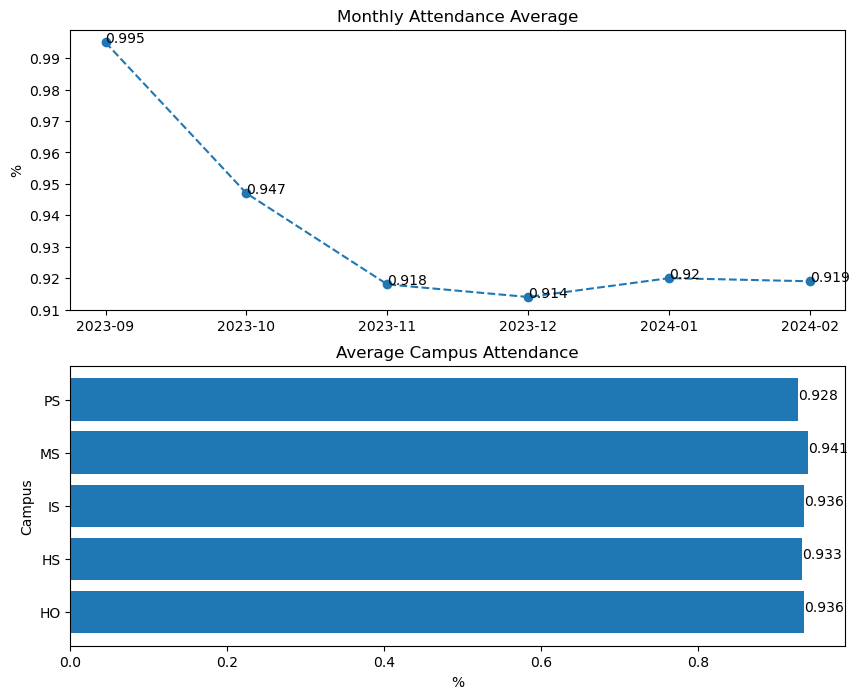

In [69]:
fig, ax = plt.subplots(nrows = 2 , ncols = 1, figsize = (10,8)) # <- creating subplots

ax[0].plot('Month', 'Att_Pct', data = month_att, marker = 'o', linestyle = '--') # <- lineplot

ax[0].set_title('Monthly Attendance Average')
ax[0].set_ylabel('%')

for index, value in enumerate(month_att['Att_Pct']):
    ax[0].text(index,value,float(value))

#Labels
ax[1].barh('Campus', 'Att_Pct', data = Campus_Att) # <- horizontal bar chart
ax[1].set_title('Average Campus Attendance')
ax[1].set_ylabel('Campus')
ax[1].set_xlabel('%')


for index,value in enumerate(Campus_Att['Att_Pct']):
    ax[1].text(value,index, float(value))